**Table of contents**<a id='toc0_'></a>    
- [中断時系列分析をする](#toc1_)    
  - [データ準備](#toc1_1_)    
  - [分析](#toc1_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
from statsmodels.tsa.deterministic import DeterministicProcess, Fourier

from MLBDataFetcher import MLBDataFetcher
from preprocess import Att_Analysis
from InterruptedTimeSeries import ITS, MITS

# <a id='toc1_'></a>[中断時系列分析をする](#toc0_)

## <a id='toc1_1_'></a>[データ準備](#toc0_)

In [2]:
att_remove_covid_addup = Att_Analysis(is_remove_covid=True, is_addup=True)
df_att_remove_covid_addup = att_remove_covid_addup.get_monthly_all_df()

## <a id='toc1_2_'></a>[分析](#toc0_)

In [9]:
its_periodical_OLS = MITS(df_att_remove_covid_addup, interventions=['2022-04','2023-04'], method='Periodic OLS', period=6, order=3)
its_periodical_OLS.show_summary()

VIF: [5.412946428571427, 2.190380489026994, 10.133333333333342, 35.09115646258506, 9.014965986394559, 9.46666666666666, 1.1603316326530602, 1.0534438775510209, 1.01781462585034, 1.0534438775510209, 1.319814379516164, 1.0267219387755102]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Attendance   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     12.28
Date:                Tue, 07 Nov 2023   Prob (F-statistic):           1.10e-09
Time:                        15:44:33   Log-Likelihood:                -782.76
No. Observations:                  54   AIC:                             1588.
Df Residuals:                      43   BIC:                             1609.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.259e+07   1.69e+05     74.280      0.000    1.22e+07    1.29e+07
time since start -2.562e+04   6882.200     -3.723      0.001   -3.95e+04   -1.17e+04
level change 0   -2.577e+06   5.58e+05     -4.622      0.000    -3.7e+06   -1.45e+06
slope change 0    5.473e+05   1.37e+05      4.001      0.000    2.71e+05    8.23e+05
level change 1   -3.208e+05   6.96e+05     -0.461      0.647   -1.72e+06    1.08e+06
slope change 1   -5.078e+05   1.81e+05     -2.807      0.007   -8.73e+05   -1.43e+05
sin(1,6)          -1.43e+05   1.11e+05     -1.289      0.204   -3.67e+05    8.08e+04
cos(1,6)         -5.394e+05   1.06e+05     -5.102      0.000   -7.53e+05   -3.26e+05
sin(2,6)          1.848e+04   1.04e+05      0.178      0.860   -1.91e+05    2.28e+05
cos(2,6)         -4.893e+05   1.06e+05     -4.628      0.000   -7.02e+05   -2.76e+05
sin(3,6)          6.138e-09   2.85e-09      2.156      0.037    3.96e-10    1.19e-08
cos(3,6)         -4.146e+04   7.38e+04     -0.562      0.577    -1.9e+05    1.07e+05
==============================================================================
Omnibus:                        6.920   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                7.359
Skew:                          -0.494   Prob(JB):                       0.0252
Kurtosis:                       4.515   Cond. No.                     4.02e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.36e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

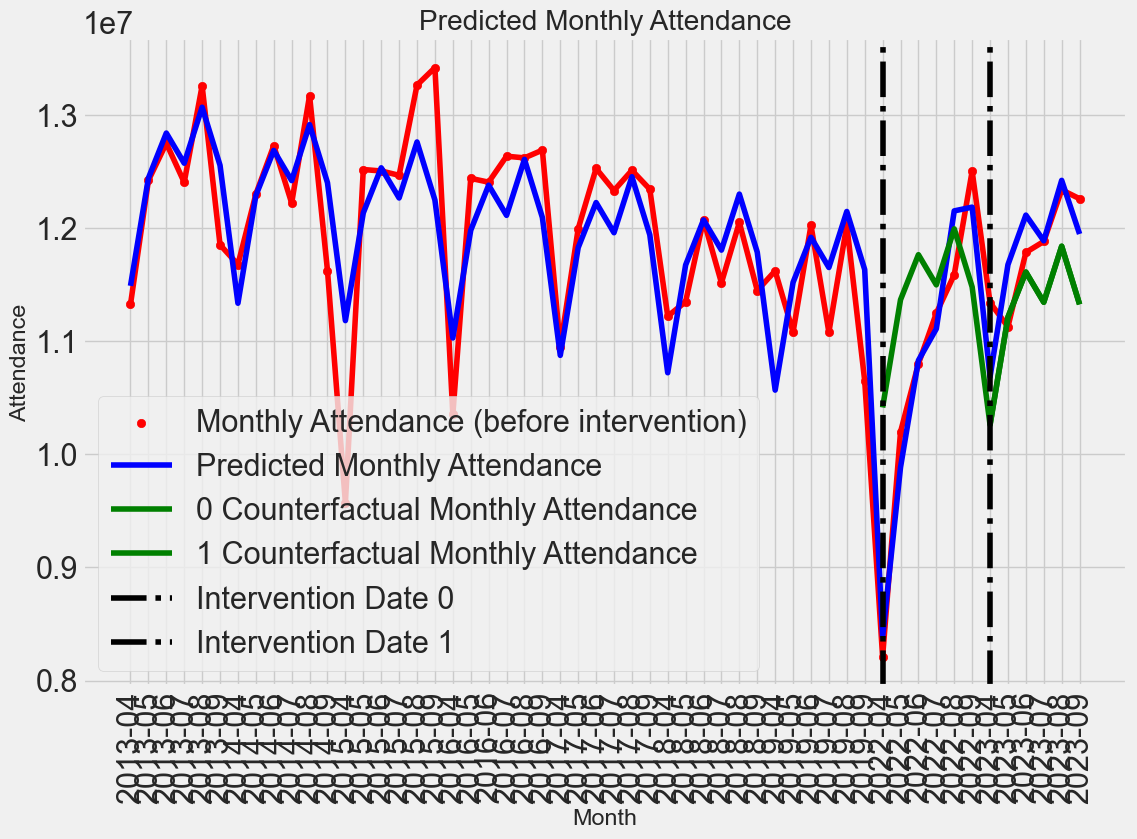

In [10]:
its_periodical_OLS.plot_predict(is_counterfactual=True)

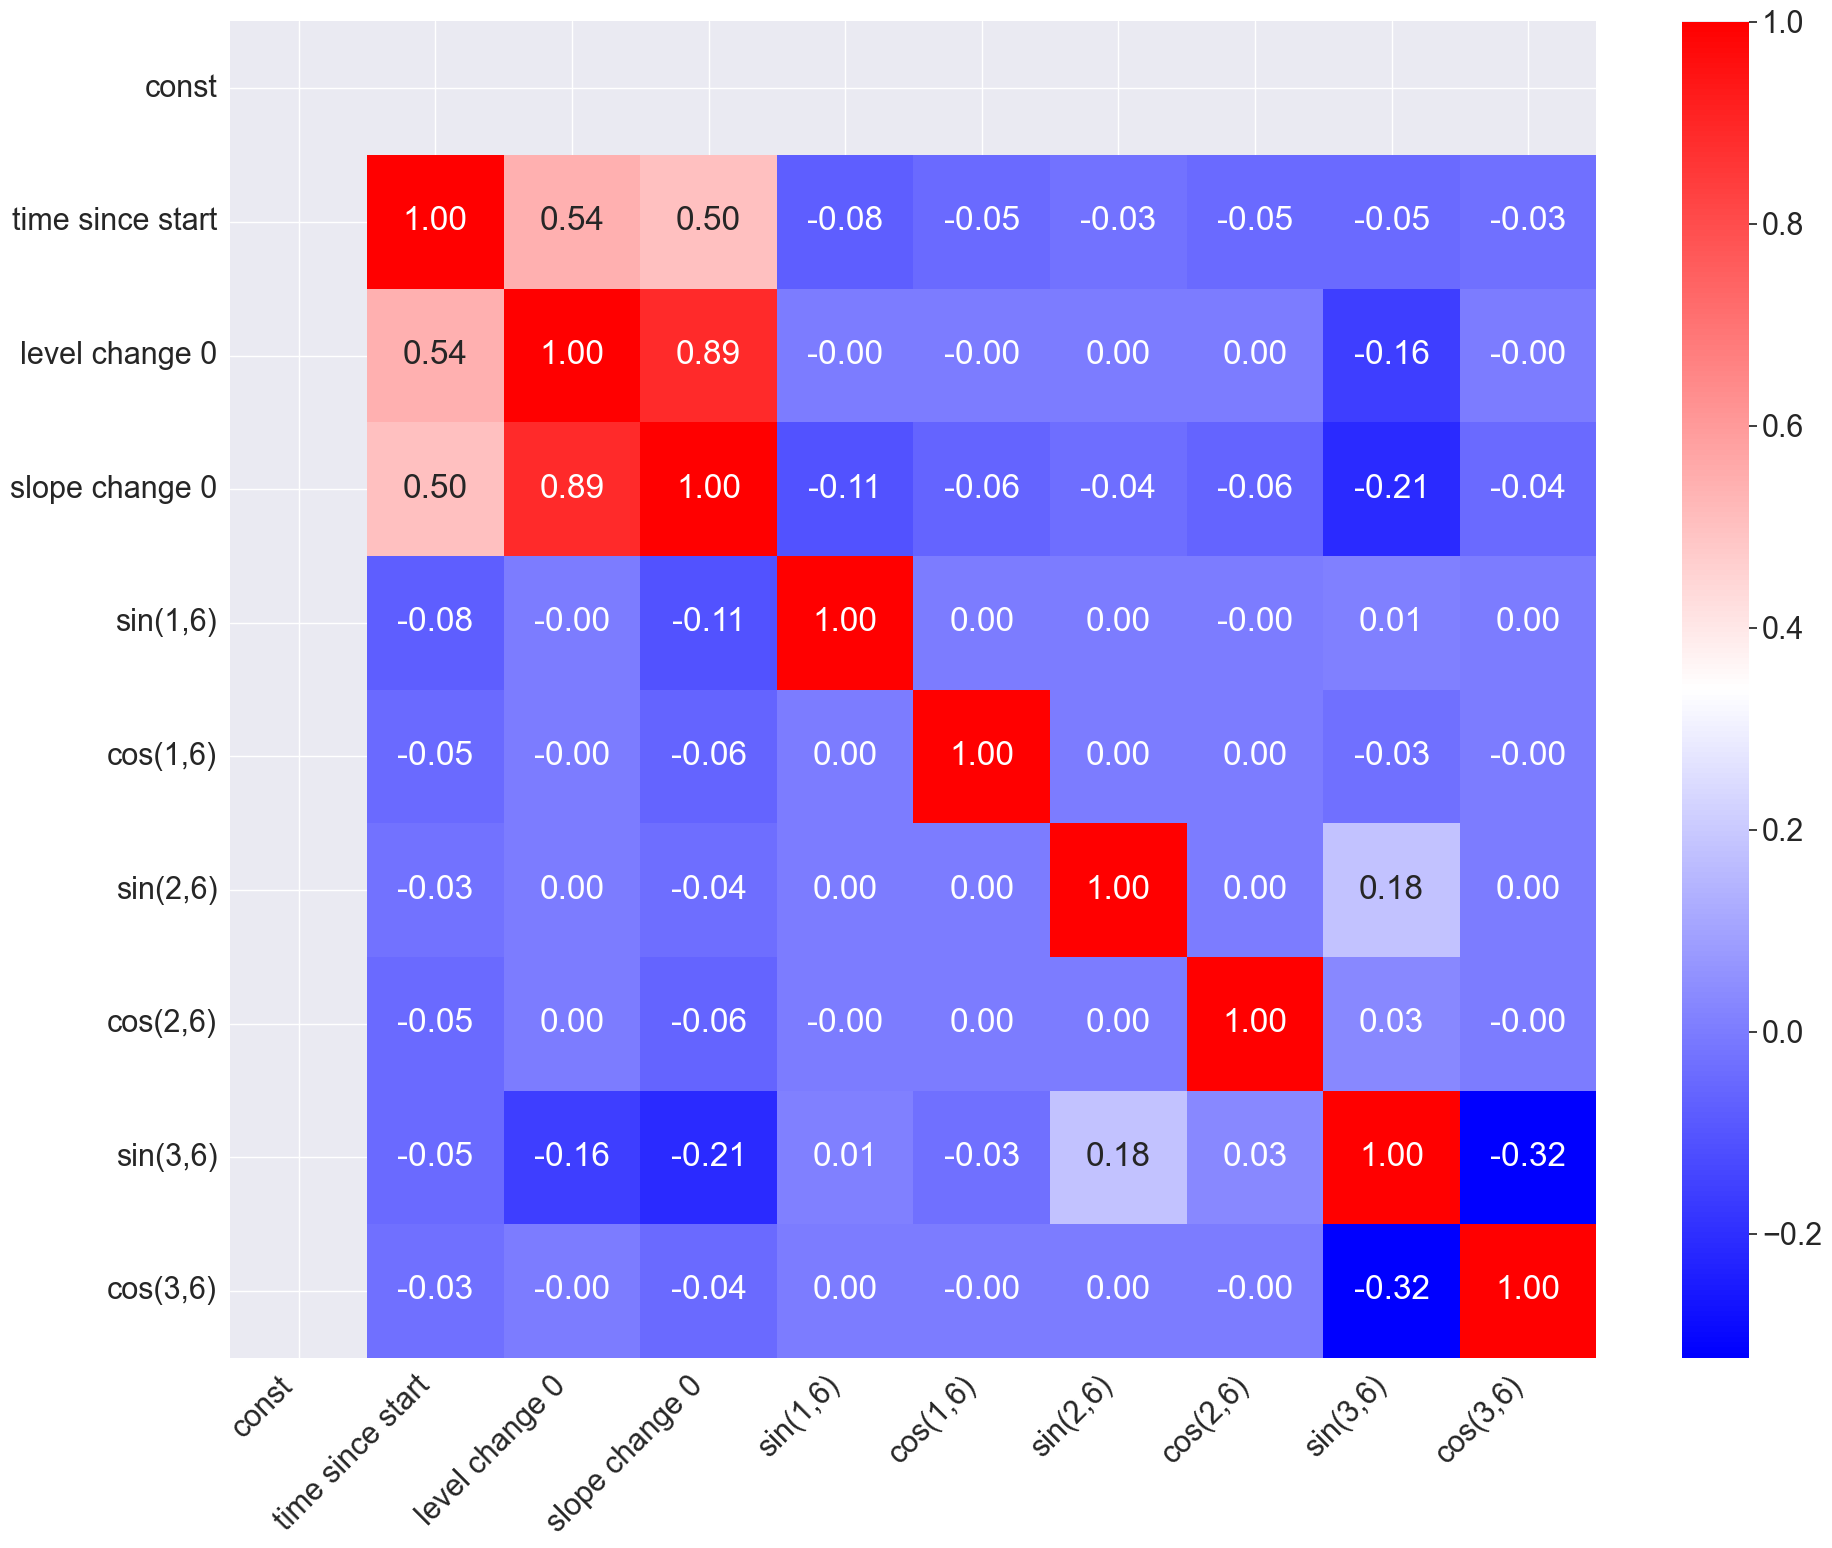

VIF: [4.697916666666666, 1.4488779620962733, 5.628571428571429, 5.324999999999996, 1.0732142857142852, 1.024404761904762, 1.0081349206349204, 1.0244047619047623, 1.2475034715293236, 1.0122023809523808]


In [6]:
its_periodical_OLS.show_correlation()

多重共線性えぐいやん。てか当たり前か笑

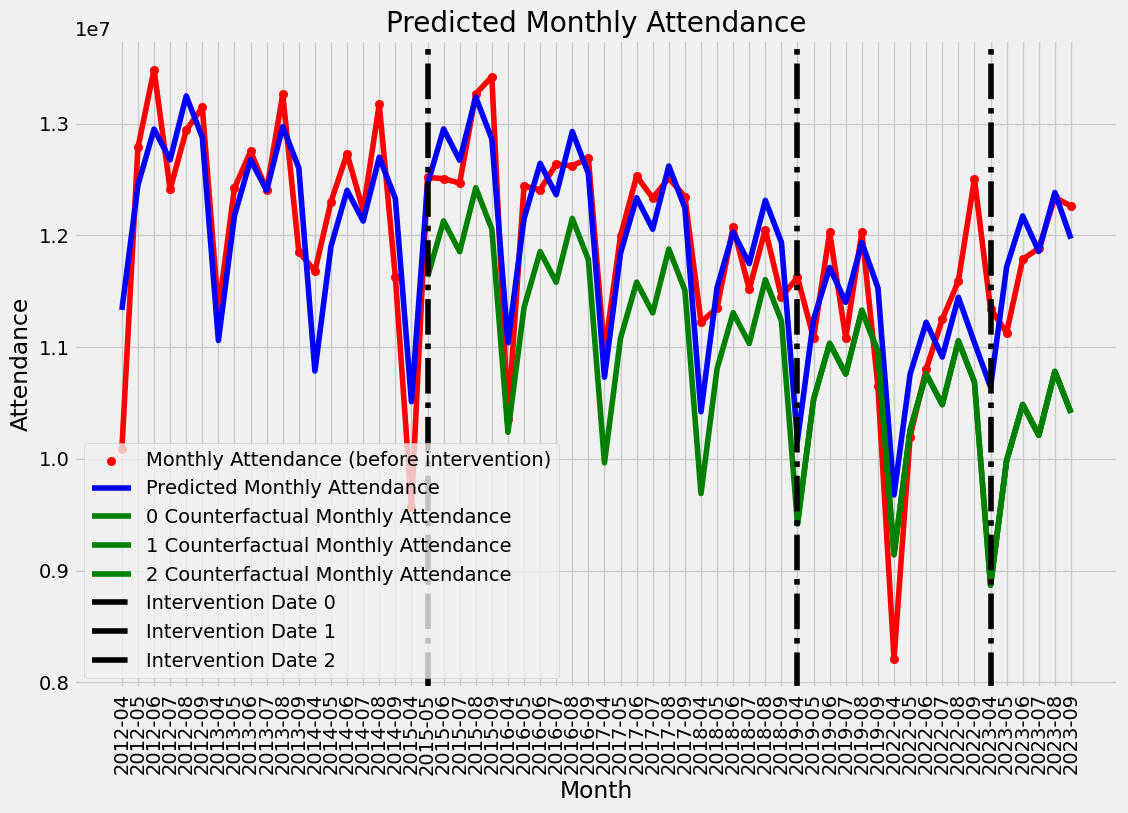

In [20]:
its_periodical_OLS.plot_predict(is_counterfactual=True)

In [19]:
its_periodical_OLS.show_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Attendance   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     8.933
Date:                Mon, 23 Oct 2023   Prob (F-statistic):           1.44e-08
Time:                        17:59:18   Log-Likelihood:                -876.89
No. Observations:                  60   AIC:                             1780.
Df Residuals:                      47   BIC:                             1807.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.275e+07   2.93e+05     43.571      0.000    1.22e+07    1.33e+07
time since start -4.567e+04   2.57e+04     -1.777      0.082   -9.74e+04    6025.593
level change 0     8.35e+05    3.8e+05      2.196      0.033    7.01e+04     1.6e+06
slope change 0   -5703.8498   3.19e+04     -0.179      0.859   -6.98e+04    5.84e+04
level change 1    8.308e+04   4.61e+05      0.180      0.858   -8.43e+05    1.01e+06
slope change 1   -3.034e+04   5.53e+04     -0.549      0.586   -1.42e+05    8.09e+04
level change 2    1.464e+06   6.99e+05      2.093      0.042    5.71e+04    2.87e+06
slope change 2   -7191.2958   1.59e+05     -0.045      0.964   -3.26e+05    3.12e+05
sin(1,6)         -2.881e+05   1.18e+05     -2.446      0.018   -5.25e+05   -5.12e+04
cos(1,6)         -6.385e+05   1.13e+05     -5.657      0.000   -8.66e+05   -4.11e+05
sin(2,6)         -6.424e+04   1.12e+05     -0.575      0.568   -2.89e+05    1.61e+05
cos(2,6)         -6.304e+05   1.13e+05     -5.585      0.000   -8.57e+05   -4.03e+05
sin(3,6)          2.462e-08   1.62e-08      1.523      0.135    -7.9e-09    5.71e-08
cos(3,6)         -1.015e+05   7.92e+04     -1.282      0.206   -2.61e+05    5.77e+04
==============================================================================
Omnibus:                        3.060   Durbin-Watson:                   1.765
Prob(Omnibus):                  0.217   Jarque-Bera (JB):                2.758
Skew:                           0.008   Prob(JB):                        0.252
Kurtosis:                       4.050   Cond. No.                     4.30e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.28e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

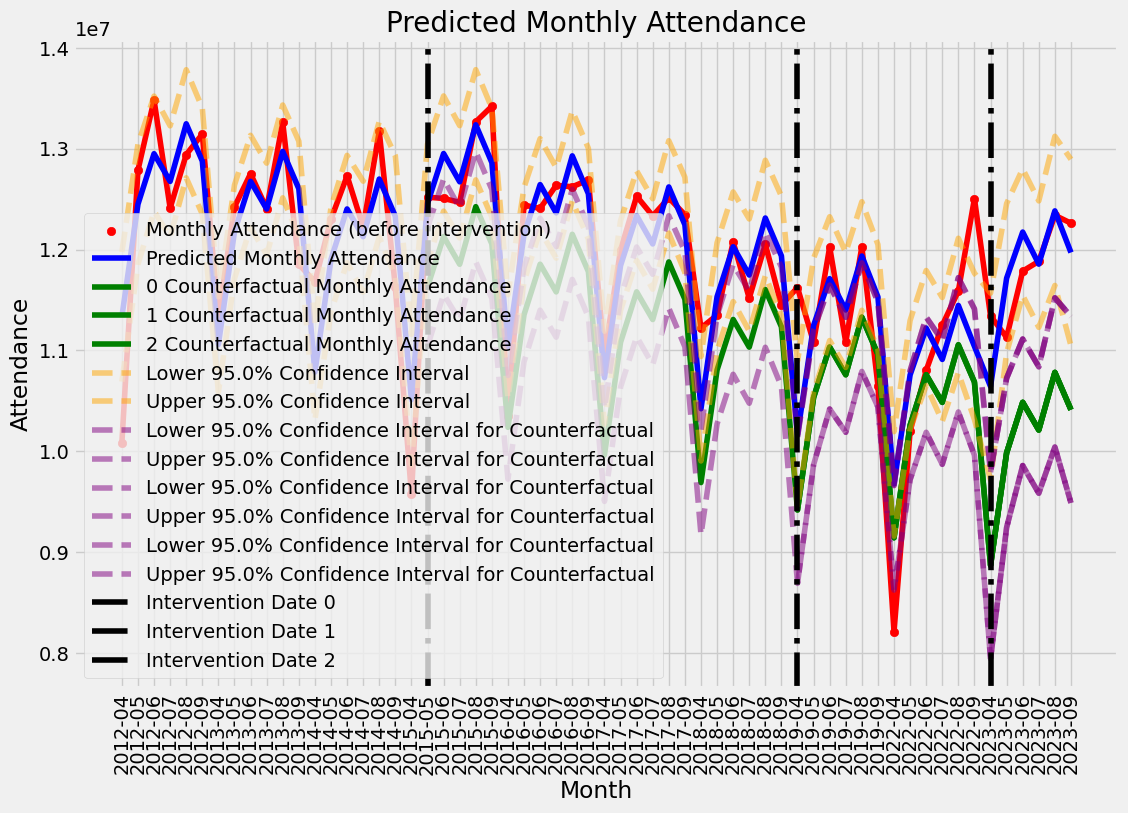

In [21]:
its_periodical_OLS.plot_predict(is_counterfactual=True, is_prediction_std=True)

In [23]:
# 使うDFを変える
df_att_remove_covid = Att_Analysis(is_remove_covid=True, is_addup=False).df_monthly_att_all_covid_removed
its_periodical_OLS = ITS(df_att_remove_covid, intervention='2023-04', method='Periodic OLS', period=8, order=3)
its_periodical_OLS.show_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Attendance   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.240
Date:                Mon, 23 Oct 2023   Prob (F-statistic):              0.288
Time:                        18:01:35   Log-Likelihood:                -1211.9
No. Observations:                  73   AIC:                             2444.
Df Residuals:                      63   BIC:                             2467.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.075e+07   1.03e+06     10.442      0.000     8.7e+06    1.28e+07
time since start -2.924e+04   2.74e+04     -1.069      0.289   -8.39e+04    2.54e+04
level change       4.51e+06    3.2e+06      1.411      0.163   -1.88e+06    1.09e+07
slope change     -1.063e+06   8.45e+05     -1.258      0.213   -2.75e+06    6.25e+05
sin(1,8)         -1.321e+06   7.24e+05     -1.826      0.073   -2.77e+06    1.25e+05
sin(2,8)          1.109e+06   7.05e+05      1.572      0.121   -3.01e+05    2.52e+06
sin(3,8)           3.14e+05   7.05e+05      0.445      0.658   -1.09e+06    1.72e+06
cos(1,8)         -5.582e+05   7.13e+05     -0.783      0.436   -1.98e+06    8.66e+05
cos(2,8)         -6.591e+05      7e+05     -0.941      0.350   -2.06e+06     7.4e+05
cos(3,8)           -6.1e+05   6.96e+05     -0.877      0.384      -2e+06    7.81e+05
==============================================================================
Omnibus:                       13.868   Durbin-Watson:                   1.305
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.864
Skew:                          -1.133   Prob(JB):                     0.000359
Kurtosis:                       3.284   Cond. No.                         277.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

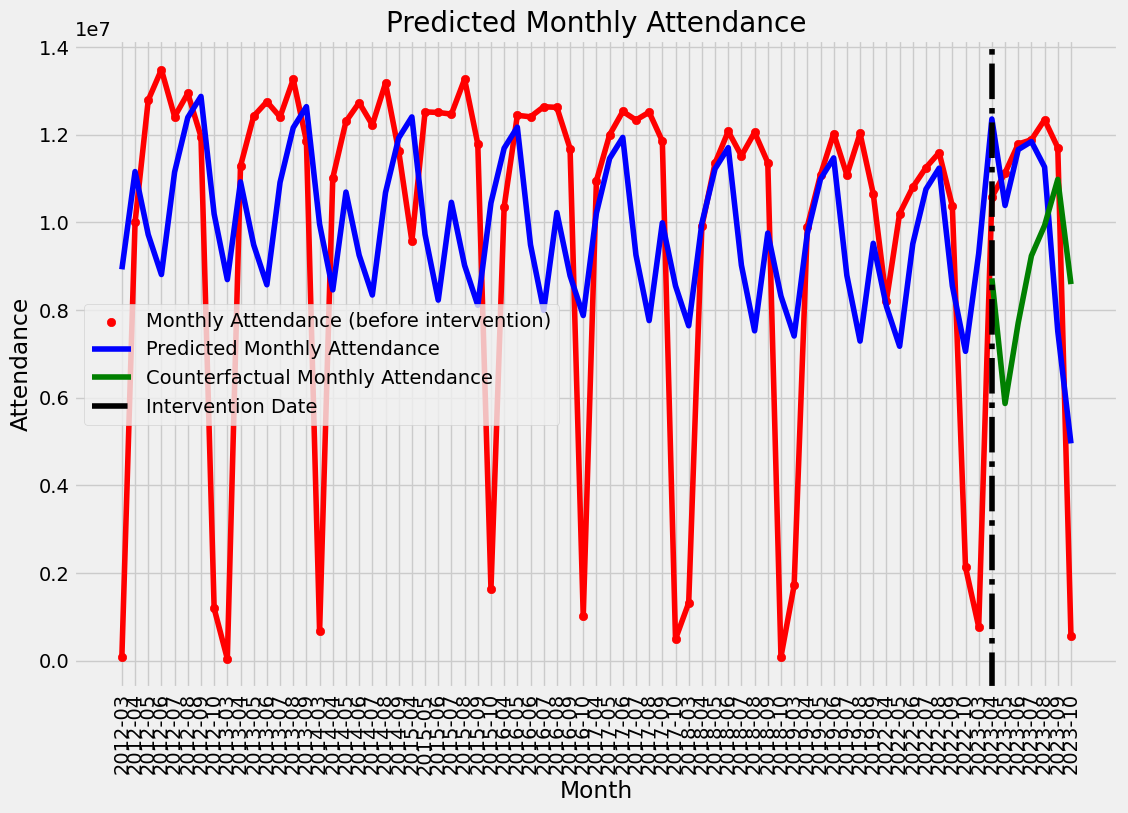

In [24]:
its_periodical_OLS.plot_predict(is_counterfactual=True)

In [6]:
## 多重共線性の確認
X = its_periodical_OLS.X
X = sm.add_constant(X)
X

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

its_periodical_OLS.plot_predict(is_counterfactual=True, is_prediction_std=True)

its_periodical_OLS.show_summary()


AttributeError: 'MITS' object has no attribute 'X'